In [4]:
from collections import OrderedDict
from dataclasses import dataclass

import numpy as np
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.optim as optim

from utils import GradientBasedPolicyDataset, GradientBasedPolicyDataset_dr


# CDR推定量_naive
@dataclass
class BasedGradientPolicyLearner_CDR:
    """勾配ベースのアプローチに基づく，履修率を最大化するオフ方策学習"""
    dim_x: int
    num_actions: int
    hidden_layer_size: tuple = (30, 30, 30)
    activation: str = "elu"
    batch_size: int = 16
    learning_rate_init: float = 0.01
    alpha: float = 1e-6
    imit_reg: float = 0.0
    log_eps: float = 1e-10
    solver: str = "adagrad"
    max_iter: int = 30
    random_state: int = 12345
    
    def __post_init__(self) -> None:
        "Initialize class"
        layer_list = []
        input_size = self.dim_x
        torch.manual_seed(self.random_state)
        
        if self.activation == "tanh":
            activation_layer = nn.Tanh
        elif self.activation == "relu":
            activation_layer == nn.ReLU
        elif self.activation == "elu":
            activation_layer  = nn.ELU
            
        for i, h in enumerate(self.hidden_layer_size):
            layer_list.append(("l{}".format(i), nn.Linear(input_size, h)))
            layer_list.append(("a{}".format(i), activation_layer()))
            input_size = h
            
        layer_list.append(("output", nn.Linear(input_size, self.num_actions)))
        layer_list.append(("softmax", nn.Softmax(dim=1)))

        self.nn_model = nn.Sequential(OrderedDict(layer_list))
        
        self.random_ = check_random_state(self.random_state)
        self.naive_value = []
        self.cate_value = []
        
        
    def fit(self, dataset:dict, dataset_test:dict,q1_hat, q0_hat ) -> None: #q1,a0を追加
        x, a, r = dataset["x"], dataset["a"], dataset["r"]
        a_mat, r_mat, pscore_mat = dataset["a_mat"], dataset["r_mat"], dataset["pscore_mat"]
        
        ## q1,q0の条件文を追加
        if q0_hat is None:
            q0_hat= np.zeros(r.shape[0], self.num_actions)
        if q1_hat is None:
            q1_hat= np.zeros(r.shape[0], self.num_actions)   
        
        if self.solver == "adagrad":
            optimizer = optim.Adagrad(
                self.nn_model.parameters(),
                lr=self.learning_rate_init,
                weight_decay=self.alpha,
            )
        elif self.solver == "adam":
            optimizer = optim.AdamW(
                self.nn_model.parameters(),
                lr=self.learning_rate_init,
                weight_decay=self.alpha,
            )
        else:
            raise NotImplementedError("`solver` must be one of 'adam' or 'adagrad'")
        
        training_data_loader = self._create_train_data_for_opl(
            x,
            a,
            r,
            a_mat,
            r_mat,           
            pscore_mat,
            q1_hat,
            q0_hat,           
        )
        
        q_x_a_1 = dataset_test["q_x_a_1"]
        q_x_a_0 = dataset_test["q_x_a_0"]
        
        for _ in range(self.max_iter):
            self.nn_model.train()
            for x_, a_, r_,  a_mat_, r_mat_, pscore_mat_, q1_hat_, q0_hat_ in training_data_loader:
                optimizer.zero_grad()
                pi = self.nn_model(x_)
                loss = -self._estimate_policy_gradient(
                    a=a_,
                    a_mat=a_mat_,
                    r=r_,
                    r_mat=r_mat_,
                    pscore_mat=pscore_mat_,
                    pi=pi,
                    q1_hat=q1_hat_,
                    q0_hat=q0_hat_,
                ).mean()
                loss.backward()
                optimizer.step()
            pi = self.predict(dataset_test)
            self.naive_value.append((pi * q_x_a_1).sum(1).mean())
            self.cate_value.append((pi * q_x_a_1 + (1.0 - pi) * q_x_a_0).sum(1).mean())

    def _create_train_data_for_opl(
        self,
        x: np.ndarray,
        a: np.ndarray,
        r: np.ndarray,
        a_mat:np.ndarray,
        r_mat: np.ndarray,           
        pscore: np.ndarray,
        q1_hat: np.ndarray,
        q0_hat:np.ndarray,
    ) -> tuple:
        dataset = GradientBasedPolicyDataset_dr(
            torch.from_numpy(x).float(),
            torch.from_numpy(a).long(),
            torch.from_numpy(r).float(),
            torch.from_numpy(a_mat).float(),
            torch.from_numpy(r_mat).float(),
            torch.from_numpy(pscore).float(),
            torch.from_numpy(q1_hat).float(),
            torch.from_numpy(q0_hat).float(),
        )

        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
        )

        return data_loader 
    
    def _estimate_policy_gradient(
        self,
        a: torch.Tensor,
        a_mat: torch.Tensor,
        r: torch.Tensor,
        r_mat: torch.Tensor,
        pscore_mat: torch.Tensor,
        pi: torch.Tensor,
        q1_hat: torch.Tensor,
        q0_hat: torch.Tensor,
    ) -> torch.Tensor:
        current_pi = pi.detach()
        log_prob1 = torch.log(pi + self.log_eps)
        log_prob2 = torch.log((1.0 - pi) + self.log_eps)
        idx = torch.arange(a.shape[0], dtype=torch.long)
        denominator = (pscore_mat * a_mat).sum(1, keepdims=True)

        estimated_policy_grad_arr = (
            (a_mat * current_pi / denominator) * (r_mat - q1_hat) * log_prob1
        ).sum(1)
        # estimated_policy_grad_arr += (
        #     (1 - a_mat) * (1.0 - current_pi) * ((r_mat - q0_hat) / (1.0 - denominator)) * log_prob2
        # ).sum(1)
        # q1_hatだけ->ちょっと悪い
        estimated_policy_grad_arr += (
            current_pi * (q1_hat) * log_prob1
        ).sum(1)
        # q0_hatだけ->ちょっと悪い
        # estimated_policy_grad_arr += (
        #     (1.0 - a_mat) * (1.0 - current_pi) * (q0_hat + q0_hat) * log_prob2
        # ).sum(1)
        
        return estimated_policy_grad_arr
    
    def predict(self, dataset_test: np.ndarray) -> np.ndarray:

        self.nn_model.eval()
        x = torch.from_numpy(dataset_test["x"]).float()
        return self.nn_model(x).detach().numpy()

# CIPS推定量_CATE
@dataclass
class CateBasedGradientPolicyLearner_CIPS:
    dim_x: int
    num_actions: int
    hidden_layer_size: tuple = (30, 30, 30)
    activation: str = "elu"
    batch_size: int = 16
    learning_rate_init: float = 0.01
    alpha: float = 1e-6
    imit_reg: float = 0.0
    log_eps: float = 1e-10
    solver: str = "adagrad"
    max_iter: int = 30
    random_state: int = 12345

    def __post_init__(self) -> None:
        """Initialize class."""
        layer_list = []
        input_size = self.dim_x
        torch.manual_seed(self.random_state)

        if self.activation == "tanh":
            activation_layer = nn.Tanh
        elif self.activation == "relu":
            activation_layer = nn.ReLU
        elif self.activation == "elu":
            activation_layer = nn.ELU

        for i, h in enumerate(self.hidden_layer_size):
            layer_list.append(("l{}".format(i), nn.Linear(input_size, h)))
            layer_list.append(("a{}".format(i), activation_layer()))
            input_size = h
        layer_list.append(("output", nn.Linear(input_size, self.num_actions)))
        layer_list.append(("softmax", nn.Softmax(dim=1)))

        self.nn_model = nn.Sequential(OrderedDict(layer_list))

        self.random_ = check_random_state(self.random_state)
        self.naive_value = []
        self.cate_value = []

    def fit(self, dataset: dict, dataset_test: dict) -> None:
        x, a, r = dataset["x"], dataset["a"], dataset["r"]
        a_mat, r_mat, pscore_mat = (
            dataset["a_mat"],
            dataset["r_mat"],
            dataset["pscore_mat"],
        )

        if self.solver == "adagrad":
            optimizer = optim.Adagrad(
                self.nn_model.parameters(),
                lr=self.learning_rate_init,
                weight_decay=self.alpha,
            )
        elif self.solver == "adam":
            optimizer = optim.AdamW(
                self.nn_model.parameters(),
                lr=self.learning_rate_init,
                weight_decay=self.alpha,
            )
        else:
            raise NotImplementedError("`solver` must be one of 'adam' or 'adagrad'")

        training_data_loader = self._create_train_data_for_opl(
            x,
            a,
            r,
            pscore_mat,
            a_mat,
            r_mat,
        )

        # start policy training
        q_x_a_1 = dataset_test["q_x_a_1"]
        q_x_a_0 = dataset_test["q_x_a_0"]
        for _ in range(self.max_iter):
            self.nn_model.train()
            for x_, a_, r_, pscore_mat_, a_mat_, r_mat_ in training_data_loader:
                optimizer.zero_grad()
                pi = self.nn_model(x_)
                loss = -self._estimate_policy_gradient(
                    a=a_,
                    a_mat=a_mat_,
                    r=r_,
                    r_mat=r_mat_,
                    pscore_mat=pscore_mat_,
                    pi=pi,
                ).mean()
                loss.backward()
                optimizer.step()
            pi = self.predict(dataset_test)
            self.naive_value.append((pi * q_x_a_1).sum(1).mean())
            self.cate_value.append((pi * q_x_a_1 + (1.0 - pi) * q_x_a_0).sum(1).mean())

    def _create_train_data_for_opl(
        self,
        x: np.ndarray,
        a: np.ndarray,
        r: np.ndarray,
        pscore: np.ndarray,
        q_hat: np.ndarray,
        pi_0: np.ndarray,
    ) -> tuple:
        dataset = GradientBasedPolicyDataset(
            torch.from_numpy(x).float(),
            torch.from_numpy(a).long(),
            torch.from_numpy(r).float(),
            torch.from_numpy(pscore).float(),
            torch.from_numpy(q_hat).float(),
            torch.from_numpy(pi_0).float(),
        )

        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
        )

        return data_loader

    def _estimate_policy_gradient(
        self,
        a: torch.Tensor,
        a_mat: torch.Tensor,
        r: torch.Tensor,
        r_mat: torch.Tensor,
        pscore_mat: torch.Tensor,
        pi: torch.Tensor,
    ) -> torch.Tensor:
        current_pi = pi.detach()
        log_prob1 = torch.log(pi + self.log_eps)
        log_prob2 = torch.log((1.0 - pi) + self.log_eps)
        denominator = (pscore_mat * a_mat).sum(1, keepdims=True)
        
        estimated_policy_grad_arr = (
            (a_mat * current_pi / denominator) * r_mat * log_prob1
        ).sum(1)
        estimated_policy_grad_arr += (
            ((1 - a_mat) * (1.0 - current_pi) / (1.0 - denominator)) * r_mat * log_prob2
        ).sum(1)

        return estimated_policy_grad_arr

    def predict(self, dataset_test: np.ndarray) -> np.ndarray:

        self.nn_model.eval()
        x = torch.from_numpy(dataset_test["x"]).float()
        return self.nn_model(x).detach().numpy()

# CDR推定量_CATE
@dataclass
class CateBasedGradientPolicyLearner_CDR:
    """勾配ベースのアプローチに基づく，履修率を最大化するオフ方策学習"""
    dim_x: int
    num_actions: int
    hidden_layer_size: tuple = (30, 30, 30)
    activation: str = "elu"
    batch_size: int = 16
    learning_rate_init: float = 0.01
    alpha: float = 1e-6
    imit_reg: float = 0.0
    log_eps: float = 1e-10
    solver: str = "adagrad"
    max_iter: int = 30
    random_state: int = 12345
    
    def __post_init__(self) -> None:
        "Initialize class"
        layer_list = []
        input_size = self.dim_x
        torch.manual_seed(self.random_state)
        
        if self.activation == "tanh":
            activation_layer = nn.Tanh
        elif self.activation == "relu":
            activation_layer == nn.ReLU
        elif self.activation == "elu":
            activation_layer  = nn.ELU
            
        for i, h in enumerate(self.hidden_layer_size):
            layer_list.append(("l{}".format(i), nn.Linear(input_size, h)))
            layer_list.append(("a{}".format(i), activation_layer()))
            input_size = h
            
        layer_list.append(("output", nn.Linear(input_size, self.num_actions)))
        layer_list.append(("softmax", nn.Softmax(dim=1)))

        self.nn_model = nn.Sequential(OrderedDict(layer_list))
        
        self.random_ = check_random_state(self.random_state)
        self.naive_value = []
        self.cate_value = []
        
        
    def fit(self, dataset:dict, dataset_test:dict,q1_hat, q0_hat ) -> None: #q1,a0を追加
        x, a, r = dataset["x"], dataset["a"], dataset["r"]
        a_mat, r_mat, pscore_mat = dataset["a_mat"], dataset["r_mat"], dataset["pscore_mat"]
        
        ## q1,q0の条件文を追加
        if q0_hat is None:
            q0_hat= np.zeros(r.shape[0], self.num_actions)
        if q1_hat is None:
            q1_hat= np.zeros(r.shape[0], self.num_actions)   
        
        if self.solver == "adagrad":
            optimizer = optim.Adagrad(
                self.nn_model.parameters(),
                lr=self.learning_rate_init,
                weight_decay=self.alpha,
            )
        elif self.solver == "adam":
            optimizer = optim.AdamW(
                self.nn_model.parameters(),
                lr=self.learning_rate_init,
                weight_decay=self.alpha,
            )
        else:
            raise NotImplementedError("`solver` must be one of 'adam' or 'adagrad'")
        
        training_data_loader = self._create_train_data_for_opl(
            x,
            a,
            r,
            a_mat,
            r_mat,           
            pscore_mat,
            q1_hat,
            q0_hat,           
        )
        
        q_x_a_1 = dataset_test["q_x_a_1"]
        q_x_a_0 = dataset_test["q_x_a_0"]
        
        for _ in range(self.max_iter):
            self.nn_model.train()
            for x_, a_, r_,  a_mat_, r_mat_, pscore_mat_, q1_hat_, q0_hat_ in training_data_loader:
                optimizer.zero_grad()
                pi = self.nn_model(x_)
                loss = -self._estimate_policy_gradient(
                    a=a_,
                    a_mat=a_mat_,
                    r=r_,
                    r_mat=r_mat_,
                    pscore_mat=pscore_mat_,
                    pi=pi,
                    q1_hat=q1_hat_,
                    q0_hat=q0_hat_,
                ).mean()
                loss.backward()
                optimizer.step()
            pi = self.predict(dataset_test)
            self.naive_value.append((pi * q_x_a_1).sum(1).mean())
            self.cate_value.append((pi * q_x_a_1 + (1.0 - pi) * q_x_a_0).sum(1).mean())

    def _create_train_data_for_opl(
        self,
        x: np.ndarray,
        a: np.ndarray,
        r: np.ndarray,
        a_mat:np.ndarray,
        r_mat: np.ndarray,           
        pscore: np.ndarray,
        q1_hat: np.ndarray,
        q0_hat:np.ndarray,
    ) -> tuple:
        dataset = GradientBasedPolicyDataset_dr(
            torch.from_numpy(x).float(),
            torch.from_numpy(a).long(),
            torch.from_numpy(r).float(),
            torch.from_numpy(a_mat).float(),
            torch.from_numpy(r_mat).float(),
            torch.from_numpy(pscore).float(),
            torch.from_numpy(q1_hat).float(),
            torch.from_numpy(q0_hat).float(),
        )

        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
        )

        return data_loader 
    
    def _estimate_policy_gradient(
        self,
        a: torch.Tensor,
        a_mat: torch.Tensor,
        r: torch.Tensor,
        r_mat: torch.Tensor,
        pscore_mat: torch.Tensor,
        pi: torch.Tensor,
        q1_hat: torch.Tensor,
        q0_hat: torch.Tensor,
    ) -> torch.Tensor:
        current_pi = pi.detach()
        log_prob1 = torch.log(pi + self.log_eps)
        log_prob2 = torch.log((1.0 - pi) + self.log_eps)
        idx = torch.arange(a.shape[0], dtype=torch.long)
        denominator = (pscore_mat * a_mat).sum(1, keepdims=True)

        estimated_policy_grad_arr = (
            (a_mat * current_pi / denominator) * (r_mat - q1_hat) * log_prob1
        ).sum(1)
        estimated_policy_grad_arr += (
            (1 - a_mat) * (1.0 - current_pi) * ((r_mat - q0_hat) / (1.0 - denominator)) * log_prob2
        ).sum(1)
        # q1_hatだけ->ちょっと悪い
        estimated_policy_grad_arr += (
            a_mat * current_pi * (q1_hat + q0_hat) * log_prob1
        ).sum(1)
        # q0_hatだけ->ちょっと悪い
        estimated_policy_grad_arr += (
            (1.0 - a_mat) * (1.0 - current_pi) * (q0_hat + q0_hat) * log_prob2
        ).sum(1)
        
        return estimated_policy_grad_arr
    
    def predict(self, dataset_test: np.ndarray) -> np.ndarray:

        self.nn_model.eval()
        x = torch.from_numpy(dataset_test["x"]).float()
        return self.nn_model(x).detach().numpy()

In [3]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from policylearners import (
    BasedGradientPolicyLearner_CIPS,
    CateBasedGradientPolicyLearner_CIPS,
    BasedGradientPolicyLearner_CDR,
    CateBasedGradientPolicyLearner_CDR,
)
from utils import (
    generate_synthetic_data,
    softmax
)

In [12]:
## シミュレーション設定
num_runs = 100 # シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
num_actions = 2 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 10000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_actions_list = [50, 100] # 行動数
num_data_list = [250, 500, 1000, 2000, 4000, 8000] # トレーニングデータのサイズ
k=5

In [13]:
result_df_data_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    ## 学習された方策の真の性能を近似するためのテストデータを生成
    test_data = generate_synthetic_data(
        num_data=test_data_size, beta=beta,
        theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
        dim_context=dim_x, num_actions=num_actions, random_state = random_state,
        k=k, random_policy=False
    )
    pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
    pi_0_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

    result_df_list = []
    for num_data in num_data_list:
        test_policy_value_list = []
        for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
            ## データ収集方策が形成する分布に従いログデータを生成
            offline_logged_data = generate_synthetic_data(
                num_data=num_data, beta=beta,
                theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
                dim_context=dim_x, num_actions=num_actions, random_state = _,
                k=k, random_policy=False
            )

            true_value_of_learned_policies = dict()
            true_value_of_learned_policies["logging"] = pi_0_value

            ## ログデータを用いてオフ方策学習を実行する
            ### CIPS_naive
            ips_naive = BasedGradientPolicyLearner_CIPS(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            ips_naive.fit(offline_logged_data, test_data)
            pi_ips_naive = ips_naive.predict(test_data)
            true_value_of_learned_policies["ips-naive"] = (pi_ips_naive * q_x_a_1 + (1 - pi_ips_naive) * q_x_a_0).sum(1).mean()
            ### CDR_naive
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(0.0, scale=0.01, size=(num_data, num_actions))
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(0.0, scale=0.01, size=(num_data, num_actions))
            cdr_naive = BasedGradientPolicyLearner_CDR(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cdr_naive.fit(offline_logged_data, test_data, q1_hat, q0_hat)
            pi_cdr_naive = cdr_naive.predict(test_data)
            true_value_of_learned_policies["cdr-naive"] = (pi_cdr_naive * q_x_a_1 + (1 - pi_cdr_naive) * q_x_a_0).sum(1).mean()
            ### CIPS_cate
            cips_cate = CateBasedGradientPolicyLearner_CIPS(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cips_cate.fit(offline_logged_data, test_data)
            pi_ips_cate = cips_cate.predict(test_data)
            true_value_of_learned_policies["cips-cate"] = (pi_ips_cate * q_x_a_1 + (1 - pi_ips_cate) * q_x_a_0).sum(1).mean()
            ### CDR_cate
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(0.0, scale=0.01, size=(num_data, num_actions))
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(0.0, scale=0.01, size=(num_data, num_actions))
            cdr_cate = CateBasedGradientPolicyLearner_CDR(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cdr_cate.fit(offline_logged_data, test_data, q1_hat, q0_hat)
            pi_cdr_cate = cdr_cate.predict(test_data)
            true_value_of_learned_policies["cdr-cate"] = (pi_cdr_cate * q_x_a_1 + (1 - pi_cdr_cate) * q_x_a_0).sum(1).mean()

            test_policy_value_list.append(true_value_of_learned_policies)

        ## シミュレーション結果の集計
        result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
            .rename(columns={"level_1": "method", 0: "value"})
        result_df["num_data"] = num_data
        result_df["pi_0_value"] = pi_0_value
        result_df["rel_value"] = result_df["value"] / pi_0_value
        result_df_list.append(result_df)
    result_df_data_list.append(pd.concat(result_df_list).reset_index(level=0))


num_data=8000...: 100%|██████████| 100/100 [1:16:18<00:00, 45.78s/it]


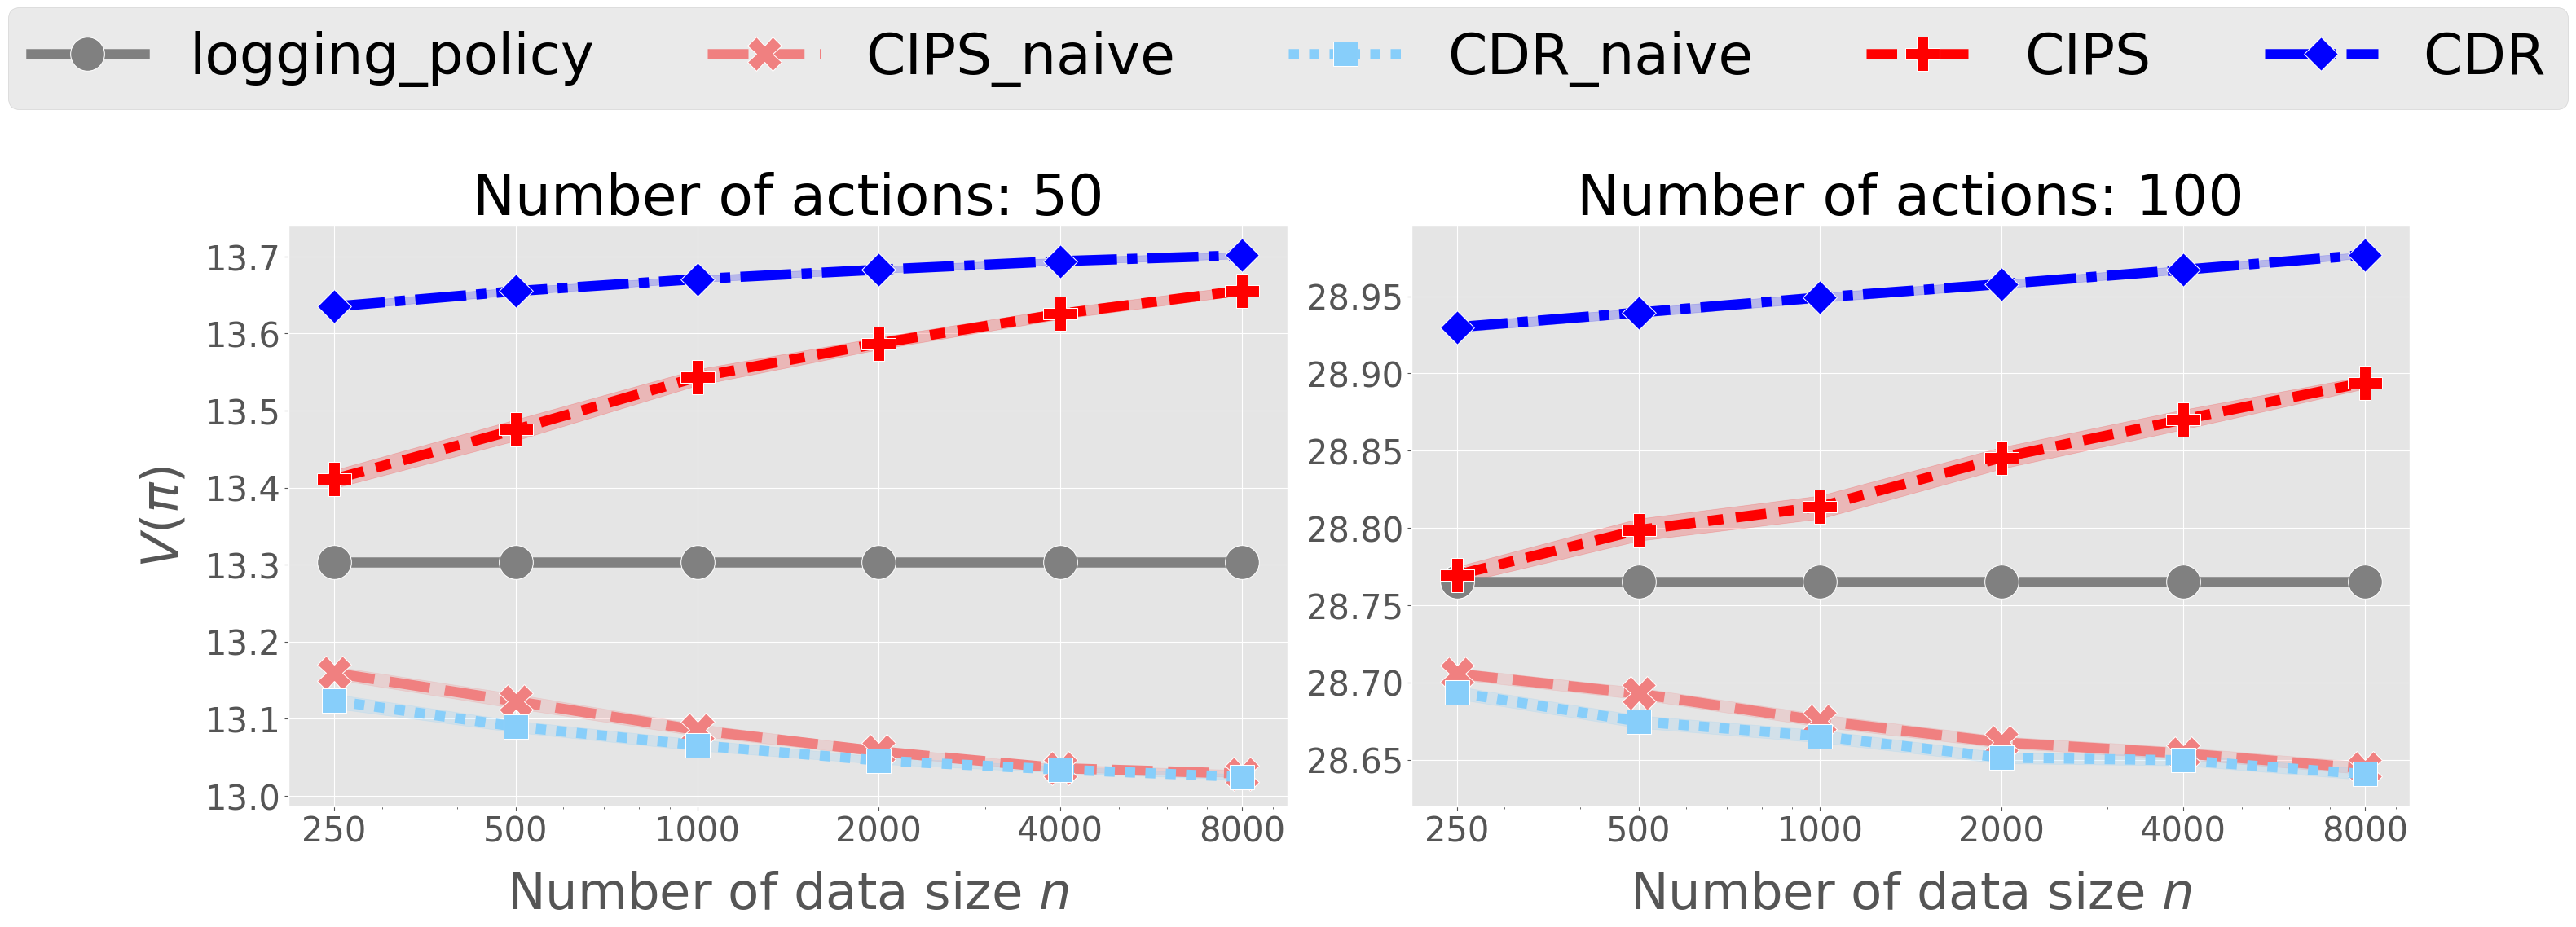

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# カスタムパレットを method 名でマッピング
custom_palette = {
    "logging": "grey",
    "ips-naive": "lightcoral",
    "cdr-naive": "lightskyblue",
    "cips-cate": "red",
    "cdr-cate": "blue"
}

fig, ax_list = plt.subplots(1, 2, figsize=(28, 9.5), tight_layout=True)

for i, (num_actions, result_df) in enumerate(zip(num_actions_list, result_df_data_list)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=9,
        markersize=30,
        markers=True,
        x="num_data",
        y="value",
        hue="method",
        style="method",
        ax=ax,
        palette=custom_palette,
        legend=False,
        data=result_df,
    )

    ax.set_title(f"Number of actions: {num_actions}", fontsize=50)

    # yaxis
    if i == 0:
        ax.set_ylabel("$V(\pi)$", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    # xaxis
    ax.set_xlabel("Number of data size $n$", fontsize=45)
    ax.set_xscale("log")
    ax.set_xticks(num_data_list)
    ax.set_xticklabels([str(n) for n in num_data_list], fontsize=30)
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())  # ラベルを整数に

    ax.xaxis.set_label_coords(0.5, -0.11)

# 共通凡例
fig.legend(
    ["logging_policy", "CIPS_naive", "CDR_naive", "CIPS", "CDR"],
    fontsize=50,
    bbox_to_anchor=(0.5, 1.13),
    ncol=5,
    loc="center"
)
